<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>Привет еще раз.</b>
Молодец ,что исправляешь ошибки. К сожалению, еще есть критические ошибки. Ниже оставил подробные комментарии.

<b>Привет!</b>

Меня зовут Евгений Лукашин, я буду проверять твой проект, постараемся вместе сделать его ещё лучше. Предлагаю обращаться к друг другу на «ты», если для тебя это будет комфортно. Иначе дай знать, и мы сразу перейдём на «вы».

Желательно отвечать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку' и т.д.) выделять их каким-либо цветом, например, так:


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Исправил.
</div>


Пожалуйста, не удаляй мои комментарии, так как они повышают качество повторного ревью, и позволят мне быстрее проверить твой проект.

<br>
Мои комментарии будут выглядеть так:

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Если все сделано правильно
</div>

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

Помни, что у нас общая цель - подготовить тебя к успешной работе Data Science  специалистом!

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#conda install tensorflow==1.12.0

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import sklearn
from sklearn.tree import DecisionTreeRegressor
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [3]:
#data = pd.read_csv('/datasets/autos.csv')
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проверим, прослеживается ли зависимость Цены от признаков: 'DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'. Для этого предварительно округлим поля с datetime до date и построим графики.

In [4]:
data['DateCrawled_to_date'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d')
data['LastSeen_to_date'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d')
data['DateCrawled_to_date'] = data['DateCrawled_to_date'].dt.round('1D')
data['LastSeen_to_date'] = data['LastSeen_to_date'].dt.round('1D')

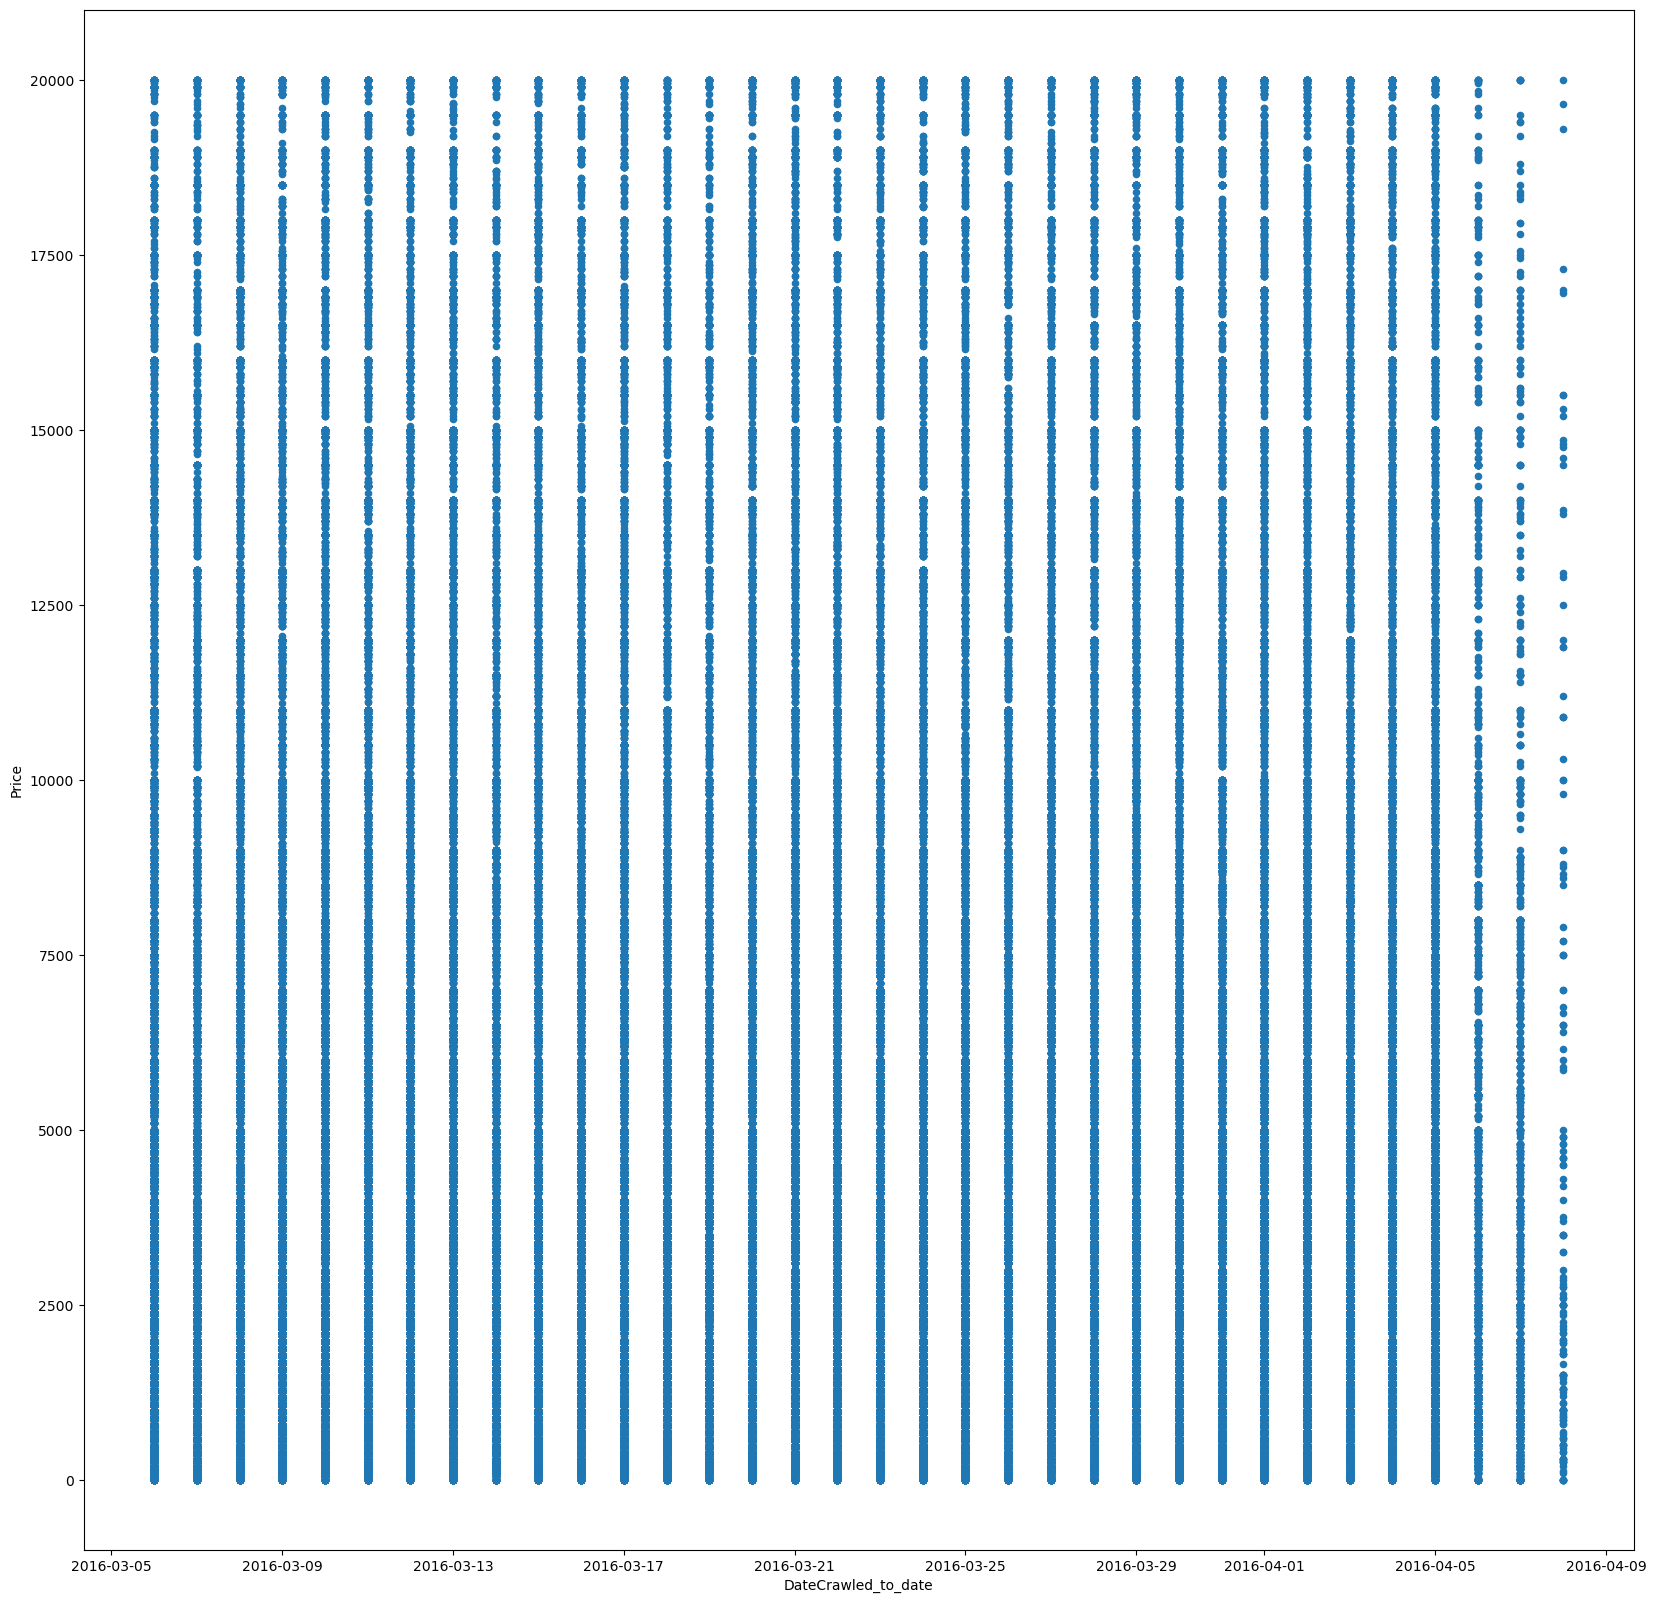

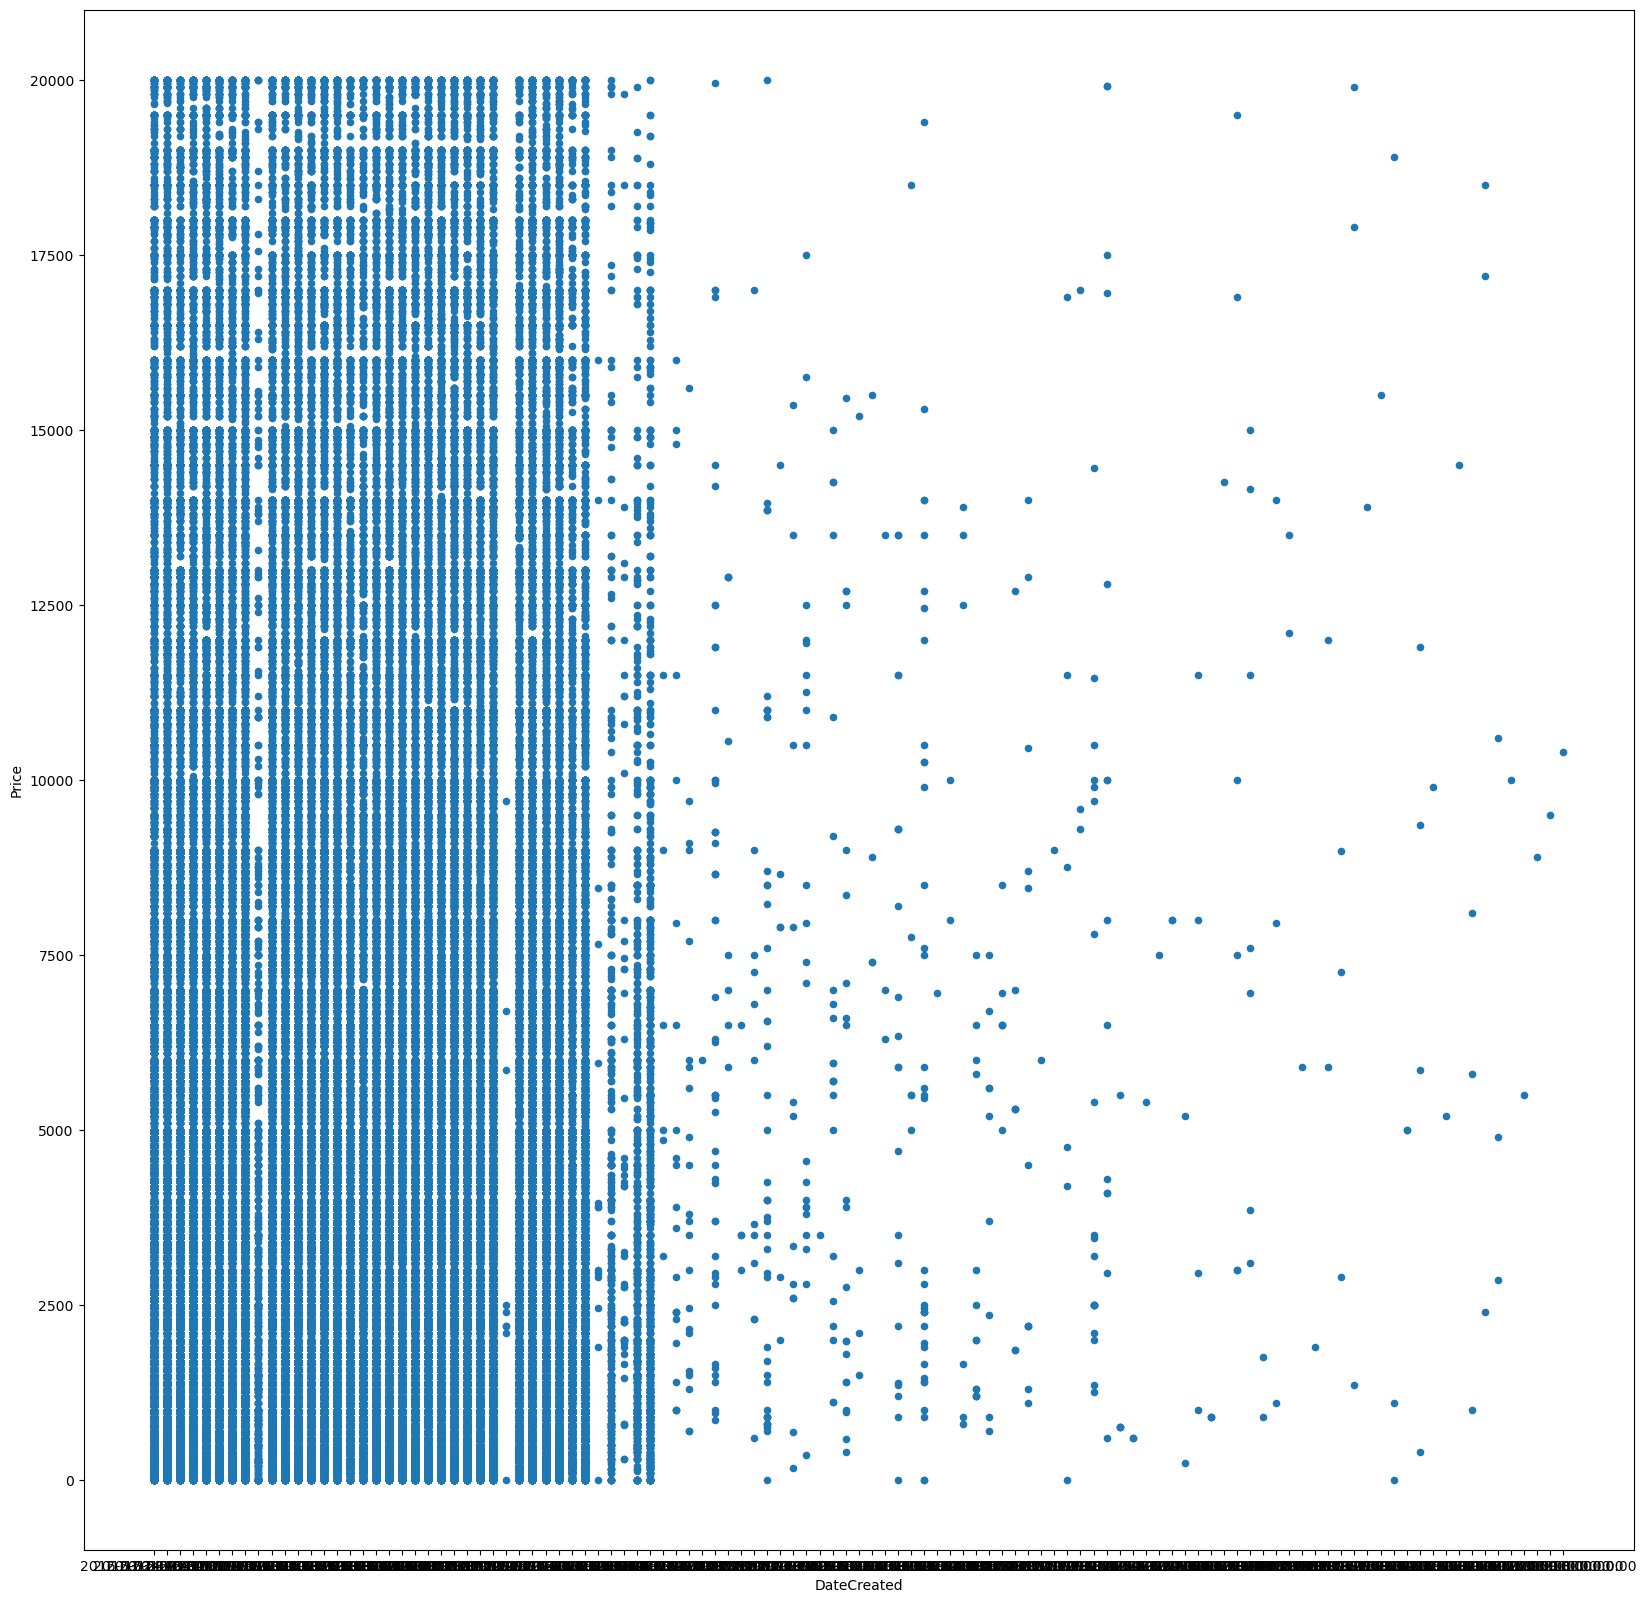

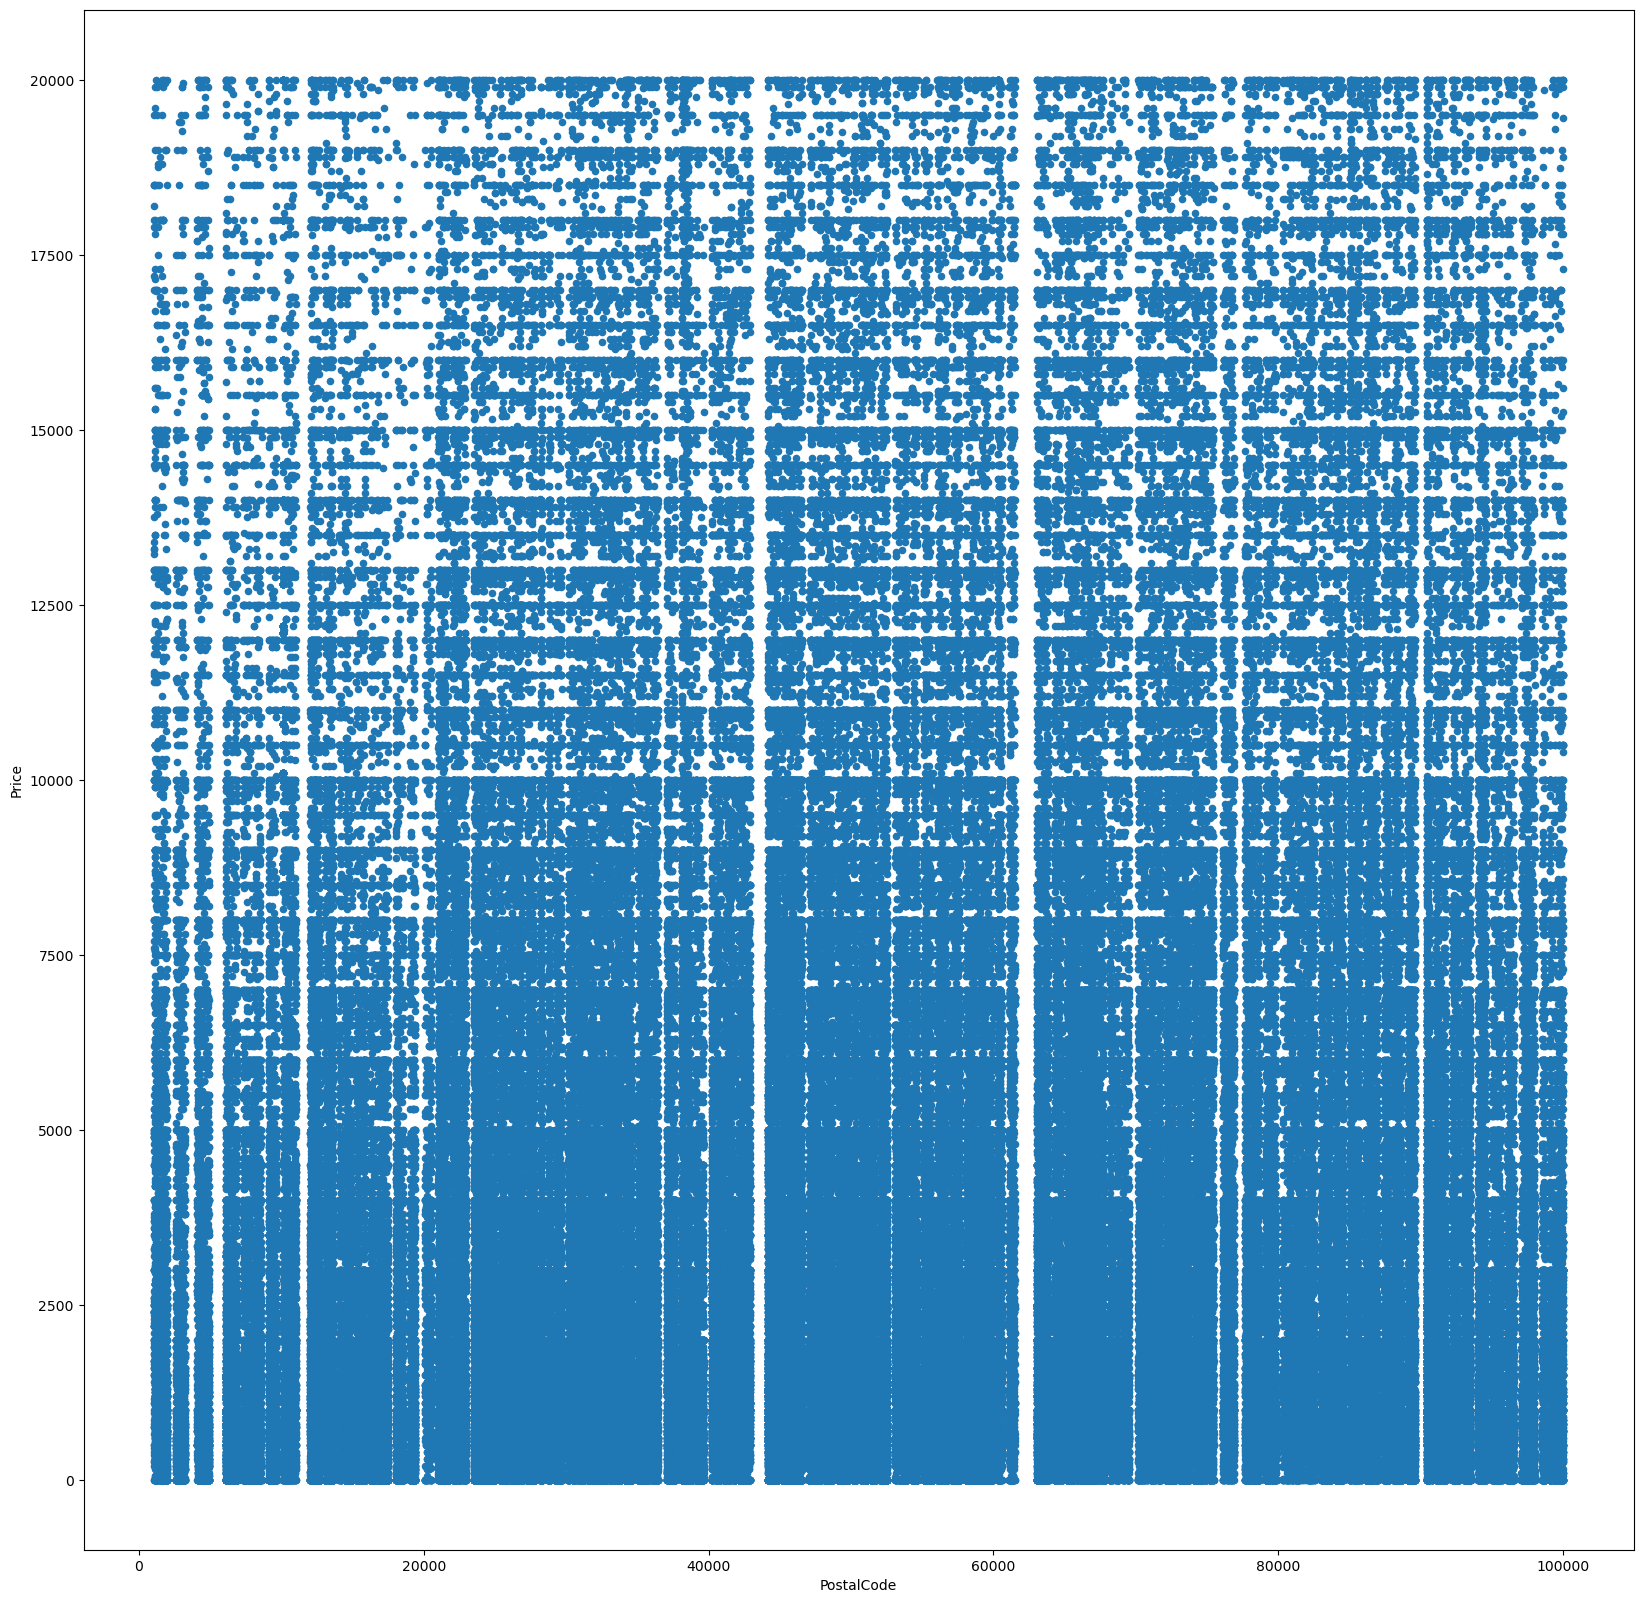

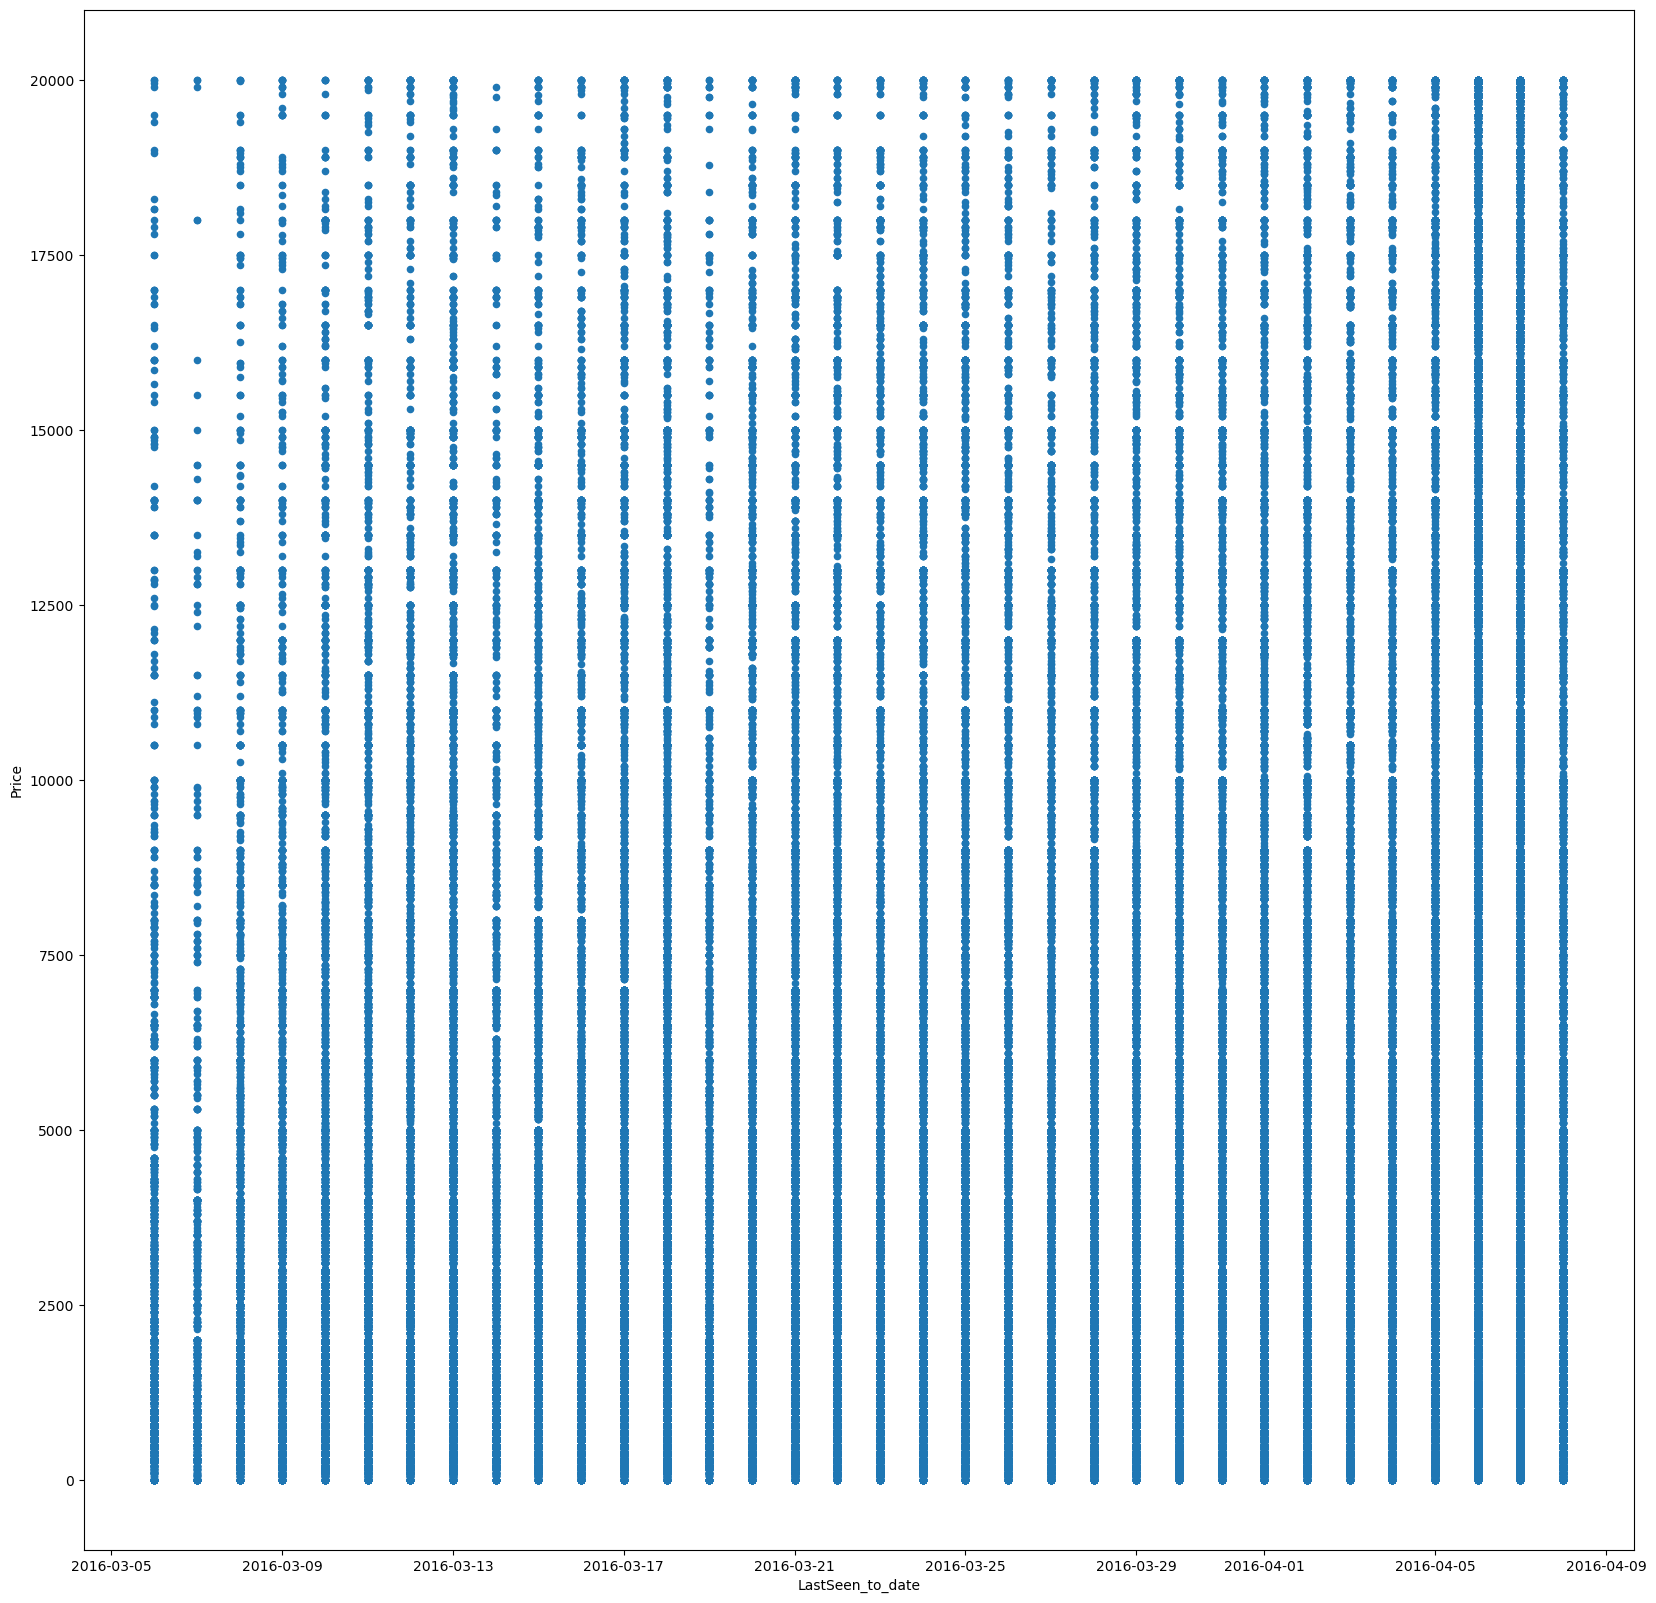

In [5]:
columns = ['DateCrawled_to_date', 'DateCreated', 'PostalCode', 'LastSeen_to_date']
for i in columns:
    data.plot(x=i, y='Price', kind='scatter', figsize=(20, 20))
    plt.show()
    

Как видно из графиков выше Цена не зависит ни от одного из указанных признаков. На графике DateCreated-Price видно, что после определенной даты кол-во наблюдений в целом сильно сокращается, но распределение цен все такое же равномерное и не имеет какой либо тенцденции. Поэтому поля с этими признаками можно смело удалить. Но сначала обработаем анолмальные значения в поле RegistrationYear.

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Не хватает анализа и обоснования удаления данных столбцов. Желательно графики где видно, что цена не зависит от данных признаков.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Готово
</div>


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> Да, теперь наглядно видно что данные признаки для обучения моделей не нужны

In [13]:
#def replace_year(row):
#    if row['RegistrationYear'] < 1980 or row['RegistrationYear'] > 2023:
#        return pd.to_datetime(row['DateCreated'], format='%Y-%m-%d').year
#    else:
#        return row['RegistrationYear']

#data['RegistrationYear'] = data.apply(replace_year, axis=1)
#data['RegistrationYear']

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Не совсем понимаю, почему нельзя просто удалить строки с выбивающимися значениями - их не так много. + также не понимаю взаимозаменяемость признаков DateCrawled и RegistrationYear, мне казалось что последний признак имеет отношение к регистрации авто в какойто гос базе?
</div>


In [22]:
#data[['RegistrationYear', 'DateCrawled']]
data = data[(data['DateCrawled_to_date'].dt.year >= data['RegistrationYear']) & (data['RegistrationYear'] >= 1980)]
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCrawled_to_date,LastSeen_to_date
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016-03-24,2016-04-07
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016-03-24,2016-04-07
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016-03-15,2016-04-06
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2016-03-18,2016-03-18
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,2016-04-01,2016-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49,2016-03-21,2016-03-21
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52,2016-03-15,2016-04-06
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12,2016-03-06,2016-03-12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26,2016-03-20,2016-04-07


<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v2:</b>

<b>⛔️«Надо исправить»:</b> Речь не про взаимозаменяемость, если ты посмотришь на DateCrawled внимательней, то увидишь, что самая поздняя дата создания анкеты 2016 год, следовательно, год регистрации не может быть больше.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Исправила выше
</div>



In [23]:
data_new = data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'DateCrawled_to_date', 'DateCreated', 'LastSeen_to_date'], axis=1)
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336387 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              336387 non-null  int64 
 1   VehicleType        313846 non-null  object
 2   RegistrationYear   336387 non-null  int64 
 3   Gearbox            319177 non-null  object
 4   Power              336387 non-null  int64 
 5   Model              319605 non-null  object
 6   Kilometer          336387 non-null  int64 
 7   RegistrationMonth  336387 non-null  int64 
 8   FuelType           309831 non-null  object
 9   Brand              336387 non-null  object
 10  Repaired           272680 non-null  object
 11  NumberOfPictures   336387 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 33.4+ MB


Как видно из описания данных выше, в данных имеются пропущенные значения. Для полей VehicleType и FuelType заполним их значением Other (оно уже присутствует в данных полях), для полей Gearbox и Repaired - обозначим их как undefined. Тип данных корректный. 

In [24]:
data_new[['VehicleType', 'FuelType']] = data_new[['VehicleType', 'FuelType']].fillna('other')
data_new[['Gearbox', 'Repaired']] = data_new[['Gearbox', 'Repaired']].fillna('undefined')
data_new['Model'] = data_new['Model'].fillna('other')

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Заменять пропущенные зачения на «other» не всегда может быть эффективным. Наблюдений с такой характеристикой достаточно немного, что говорит о низкой вероятности встретить это значение.

Пропущенные значения признака FuelType можно заменить, например, модой с группировкой по модели автомобиля и году регистрации - то есть самым часто встречающимся значением для конкретной модели, зарегистрированной в конкретный год. То же самое можно отнести и к другим признакам

In [25]:
data_new.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
count,336387.000000,336387.000000,336387.000000,336387.000000,336387.000000,336387.0
mean,4447.274794,2002.828894,111.366973,128513.839714,5.770615,0.0
std,4526.680863,6.081984,185.510237,37473.848050,3.707441,0.0
min,0.000000,1980.000000,0.000000,5000.000000,0.000000,0.0
25%,1099.000000,1999.000000,70.000000,125000.000000,3.000000,0.0
50%,2750.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6499.000000,2007.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,0.0


Поле RegistrationMonth содержит порядка 36к нулевых значений. Очевидно, удалить 36к строк будет слишком затратно, поэтому заменим их на 1. В целом мне кажется месяц регистрации не так критичен как год регистрации, и небольшая неточность внутри года не скажется на качестве модели.

In [26]:
def replace(row):
    if row['RegistrationMonth'] == 0:
        return 1
    else:
        return row['RegistrationMonth']

data_new['RegistrationMonth'] = data_new.apply(replace, axis=1)
data_new['RegistrationMonth'].unique()

array([ 1,  5,  8,  6,  7, 10, 12, 11,  2,  3,  4,  9])

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Да, согласен с тобой
</div>

Удалим строки с нулевыми значениями в полях Price, Power. Их суммарно около 1% от всей выборки. Удалим также поле NumberOfPictures тк оно содержит только нули и оттого не информативно.

In [27]:
data_new = data_new.loc[(data_new['Price'] != 0) & (data_new['Power'] != 0)]
data_new = data_new.drop('NumberOfPictures', axis=1)

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Да, с таргетом лучше не выдумывать и удалить нули. Но нули признака power можно попытаться заполнить
</div>

Посмотрим на рапределения значений в числовых полях.

(0.0, 20000.0)

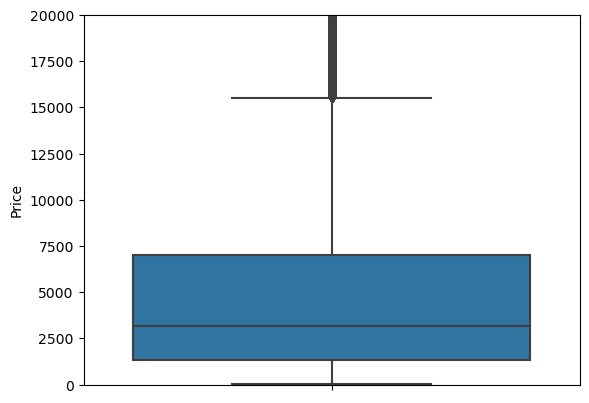

In [28]:
#data_new['Price'].plot(kind='hist', bins=20)
sns.boxplot(data=data_new, y='Price')
plt.ylim(0, 20000)



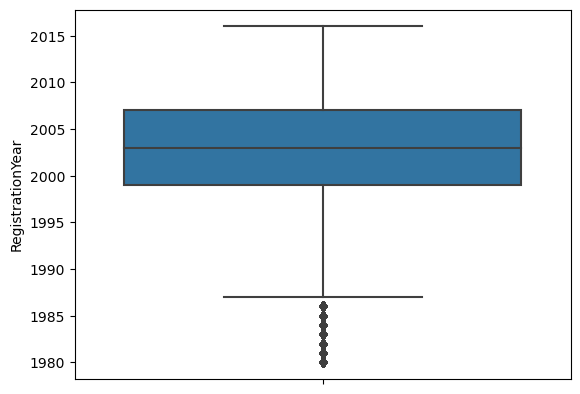

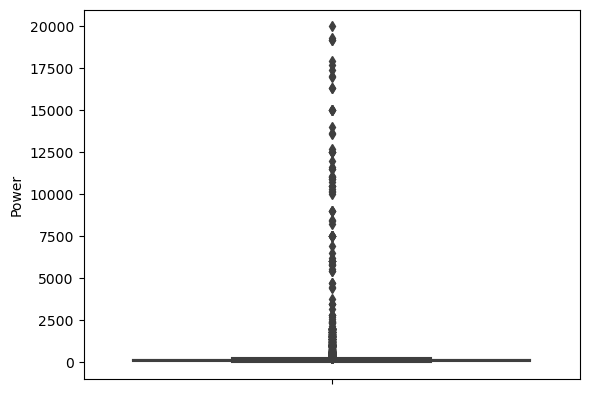

In [29]:
sns.boxplot(data=data_new, y='RegistrationYear')
plt.show()

sns.boxplot(data=data_new, y='Power')
plt.show()

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Для 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ??
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> Сорри. Видимо ,что-то хотел написать про power

In [ ]:
#data_new['RegistrationYear'].sort_values().unique()

In [ ]:
#data_new['Power'].sort_values().unique()

Судя по графикам ящик с усами и таблице с ОС, мы также можем удалить выбивающиеся значения - цены <s>выше 15к и</s> ниже 100 евро, строки с годом регистрации позже 2023 и раньше 1990 г, уровнем мощности <s>выше 150 и</s> ниже 30.

In [30]:
data_new = data_new.loc[(data_new['Price'] >= 100)] #& (data_new['RegistrationYear'] <= 2023) & (data_new['RegistrationYear'] >= 1990)]
data_new = data_new.loc[(data_new['Power'] > 30)]

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> 
    По price и power согласен, а вот registration_year необходимо проанализировать внимательней. Обрати внимание на столбцы DateCrawled и/или DateCreated
</div>


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Поправила выше
</div>

In [31]:
(data_new.shape[0] / data.shape[0]) * 100

87.0735194879707

Если не ошибаюсь, рекомендуется срезать максимум 10% исходной выборки, но я итак старалась сильно не фильтровать данные, убрала то что прям оч сильно выбивается и потенциально может исказить результаты моделирования.

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Удаление 16 % данных это неплохой результат. Здесь было бы здорово написать промежуточный вывод  

## Обучение моделей

In [ ]:
print(lightgbm.__version__)

<s>Разобьем данные на обучающую, валидационную и тестовую выборки в пропорции 60-20-20%.</s>

In [33]:
features = data_new.drop('Price', axis=1)
target = data_new['Price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)
#features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)
#print(features_train.shape)
#print(features_valid.shape)
#print(features_test.shape)

Прежде чем перейти к обучению модели необходимо закодировать категориальные признаки методом OHE.

In [34]:
cat_list = ['Repaired', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']

pd.set_option('display.max_columns', None)
features_ohe_train = features_train.copy()
features_ohe_test = features_test.copy()
# создадим объект класса OHE
enc = OneHotEncoder(sparse_output=False, handle_unknown='error', drop='first') # sparse=False - выдать результат не в сжатом виде; в версии > 1.2 sparse_out, handle_unknown='ignore' - результирующие закодированные столбцы для фичи, в кот-ой встречаются неизвестные категории, будут нулевыми.
enc.fit(features_train[cat_list])
enc_data_train = pd.DataFrame(enc.transform(features_train[cat_list])) # fits transformer to data then transforms it
enc_data_test = pd.DataFrame(enc.transform(features_test[cat_list]))
#enc_data

#enc.categories_
#Добавим названия столбцов в новую матрицу признаков
#enc.get_feature_names(['Repaired', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand'])
enc_data_train.columns = enc.get_feature_names_out(cat_list) #в старой версии get_feature_names
enc_data_test.columns = enc.get_feature_names_out(cat_list)
#enc_data
#Присоединим новые признаки к исходной таблице, удалив старые признаки
features_ohe_train = pd.concat([features_ohe_train.reset_index(), enc_data_train], axis=1)
features_ohe_test = pd.concat([features_ohe_test.reset_index(), enc_data_test], axis=1)
features_ohe_train = features_ohe_train.drop(cat_list, axis=1)
features_ohe_test = features_ohe_test.drop(cat_list, axis=1)


<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Обучение (fit) проводим только на тренировочной выборке, применяем обученный кодировщик (transform) на всех выборках (train, test, если есть valid).

</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Готово
</div>

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v2:</b>
 
<b>⛔️«Надо исправить»:</b> Применяешь энкодер к выборке features, а не к features_train и features_test. ТАкже можно сделать список с категориальными переменными ч.тобы каждый раз их не перечислять
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Исправила выше
</div>

Вопрос: Я хотела установить параметр handle_unknown='ignore', но JN ругается тк уже присутсвует параметр drop='first.
Как это можно обойти и нужно ли? В одном из предыдущих проектов я пользовалась методом get_dummies(), на что мне ревьюер ответил что по хорошему нужно использовать метод от sklearn - в чем концептуальное преимущество этого метода?

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Get_dummies подходит для анализа данных, а для машинного обучения более предпочтителен OHE, т.к. он позволяет избежать ряд ошибок при обучении моделей, в том числе может работать с неизвестными ранее категориями, которых не было изначально, а также get_dummies не вставить в пайплайны. <a href='https://pythonsimplified.com/difference-between-onehotencoder-and-get_dummies/'>Статья "Разница между OneHotEncoder и get_dummies"</a>

<a href='https://colab.research.google.com/drive/1_gAMXcQKoCShB_l8FNtYEejMnosm9mvt?usp=sharing'>Блокнот с  примером</a>

Применяnь drop='first' нужно, иначе есть риск попасть в dummy ловушку. Для применения параметра drop='first', необходимо устнаовить параметр handle_unknown='error'
</div>

Почему то nan значения в новых столбцах...

В общем изза nan не получается обучить модель... Использую get_dammies()
Вообще в доке указано что для LightGBM дополнительно не нужно кодировать категориальные признаки, это действительно так? Мне не удалось запустить модель сразу на исходных данных, тк выдавало ошибку: ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: VehicleType, Gearbox, Model, FuelType, Brand, Repaired

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> У lgbm и catboost есть встроенные методы кодирования категориальных переменных. Они, как правило, справляются лучше стандартных. Для кодирования у данных моделей есть специальные параметры, через которые можно указать перечень признаков, требующих кодирования (хотя дефолтно модели сами могут определить, какие из признаков являются категориальными, это не всегда работает надежно, поэтому во избежание недопонимания с моделью лучше вручную прописать нуждающиеся в кодировании признаки): categorical_feature и cat_features соответственно. Для lgbm необходимо привести категориальные фичи к типу данных category

In [ ]:
#df_ohe = pd.get_dummies(data_new, drop_first=True)
#df_ohe

In [ ]:
#import lightgbm as lgb
#print(lgb.__version__)
#from lightgbm import LGBMRegressor

#features_new = df_ohe.drop('Price', axis=1)
#target_new = df_ohe['Price']
#features_train_new, features_test_new, target_train_new, target_test_new = train_test_split(features_new, target_new, test_size=0.25, random_state=12345)

In [ ]:
#pd.set_option('display.max_columns', None)
#features_new

Попробуем подобрать наиболее оптимальные значения гиперапараметров для модели LightGBM(), в частности кол-во деревьев и глубину дерева.

In [ ]:
#del features, target, features_train, features_test, target_train, target_test, data, data_new, enc_data

In [39]:


#features = data_new_ohe.drop('Price', axis=1)
#target = data_new['Price']

#features_train, features_test, target_train, target_test = train_test_split(features_ohe_train, target, test_size=0.25, random_state=12345)

In [ ]:
#from sklearn.metrics import mean_squared_error

#model = LGBMRegressor(n_estimators=10, max_depth=2, random_state=12345)
#model.fit(features_train, target_train)
#predicted_test = model.predict(features_test)
#print(mean_squared_error(target_test, predicted_test))

In [43]:

start_time = time.time()

best_model_lgbm = None
best_score_lgbm = -2499
best_depth_lgbm = 1
best_n_estimators = 1

for depth in tqdm(range(10, 21)):
    for n in [1000, 1500, 2000, 2500]:
        model = LGBMRegressor(n_estimators=n, max_depth=depth, random_state=12345)
        rmse = cross_val_score(model, features_ohe_train, target_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, error_score='raise').mean()
        print(rmse, depth, n)
        if rmse > best_score_lgbm:
            best_model_lgbm = model
            best_score_lgbm = rmse
            best_depth_lgbm = depth
            best_n_estimators = n
print(best_score_lgbm, best_depth_lgbm, best_n_estimators)
print("--- %s seconds ---" % (time.time() - start_time))        

  0%|                                                                | 0/11 [00:00<?, ?it/s]

-1517.4485146984541 10 1000
-1509.1787076074731 10 1500
-1506.9761119633883 10 2000


  9%|█████                                                   | 1/11 [01:25<14:12, 85.26s/it]

-1507.8474943357523 10 2500
-1516.4056698633458 11 1000
-1509.2275812442585 11 1500
-1506.9005588738116 11 2000


 18%|██████████▏                                             | 2/11 [02:46<12:24, 82.73s/it]

-1506.9860338362805 11 2500
-1517.0491484879265 12 1000
-1509.3392490900517 12 1500
-1507.3239422029064 12 2000


 27%|███████████████▎                                        | 3/11 [04:05<10:49, 81.14s/it]

-1507.0968714146193 12 2500
-1517.697340767516 13 1000
-1508.4575564821246 13 1500
-1506.1032076348572 13 2000


 36%|████████████████████▎                                   | 4/11 [05:24<09:21, 80.20s/it]

-1506.6238337358654 13 2500
-1516.82091998516 14 1000
-1508.6468759199809 14 1500
-1505.7047264292135 14 2000


 45%|█████████████████████████▍                              | 5/11 [06:43<07:58, 79.75s/it]

-1506.0521072016784 14 2500
-1517.2081983660235 15 1000
-1509.9925709164972 15 1500
-1507.7210158120777 15 2000


 55%|██████████████████████████████▌                         | 6/11 [08:02<06:37, 79.44s/it]

-1507.4348766343094 15 2500
-1515.8642111710433 16 1000
-1508.9998931901507 16 1500
-1506.391710589666 16 2000


 64%|███████████████████████████████████▋                    | 7/11 [09:21<05:17, 79.46s/it]

-1506.3147540769103 16 2500
-1516.0988240129375 17 1000
-1507.9834747521681 17 1500
-1505.9692793999905 17 2000


 73%|████████████████████████████████████████▋               | 8/11 [10:40<03:58, 79.35s/it]

-1505.8560474339674 17 2500
-1515.7159307942393 18 1000
-1507.9581963310445 18 1500
-1505.9664636083737 18 2000


 82%|█████████████████████████████████████████████▊          | 9/11 [12:00<02:39, 79.54s/it]

-1505.9612185669405 18 2500
-1516.0441065448867 19 1000
-1508.3327869749535 19 1500
-1505.4586758657406 19 2000


 91%|██████████████████████████████████████████████████     | 10/11 [13:20<01:19, 79.50s/it]

-1506.116907145982 19 2500
-1516.3096880039193 20 1000
-1509.353609361816 20 1500
-1506.5750040887535 20 2000


100%|███████████████████████████████████████████████████████| 11/11 [14:39<00:00, 79.97s/it]

-1506.691483288235 20 2500
-1505.4586758657406 19 2000
--- 879.6766550540924 seconds ---


<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> 
Лучшими гиперпараметрами получились крайние значения в диапазонах, рекомендую увеличить диапазоны, так как есть вероятность, что гиперпараметры не оптимальны.

</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Увеличила значения перебираемых гиперпараметров.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> 👍

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Get_dummies и OHE не желательны для моделей на основе дерева. Они сильно замедляют работу данных моделей.

Для подбора кодировщика можешь пользоваться данной <a href="https://www.kaggle.com/getting-started/159882"> схемой </a>.


</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Тут на шаге <15 Cardinality? что бы мне пришлось выбрать?
                                             </div>




<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> <b>??</b>
</div>





Итак, при глубине дерева  <s>10</s> 11, кол-вом деревьев <s>1000</s> 2500 модель выдает RMSE = <s>1500</s> 1566, что соответствует нашему критерию RMSE < 2000. Подбор гиперпараметров занял <s>55 мин</s> 14 мин <b>на локале.</b>

Для сравнения обучим также простую модель ДР.

In [45]:


best_model_dt = None
best_score_dt = -2499
best_depth_dt = 1

for depth in tqdm(range(10, 21)):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    rmse = cross_val_score(model, features_ohe_train, target_train, cv=3, scoring='neg_root_mean_squared_error', error_score='raise').mean()
    print(rmse, depth, n)
    if rmse >= best_score_dt:
            best_model_dt = model
            best_score_dt = rmse
            best_depth_dt = depth
print(best_score_dt, best_depth_dt)  
    
        

  9%|█████                                                   | 1/11 [00:04<00:43,  4.38s/it]

-1957.276850578961 10 2500


 18%|██████████▏                                             | 2/11 [00:09<00:41,  4.56s/it]

-1920.9554782351006 11 2500


 27%|███████████████▎                                        | 3/11 [00:13<00:37,  4.73s/it]

-1895.0280492445509 12 2500


 36%|████████████████████▎                                   | 4/11 [00:19<00:34,  4.88s/it]

-1881.9900981550898 13 2500


 45%|█████████████████████████▍                              | 5/11 [00:24<00:30,  5.04s/it]

-1881.6363114306623 14 2500


 55%|██████████████████████████████▌                         | 6/11 [00:29<00:25,  5.16s/it]

-1890.3395752527601 15 2500


 64%|███████████████████████████████████▋                    | 7/11 [00:35<00:21,  5.32s/it]

-1903.9379478763483 16 2500


 73%|████████████████████████████████████████▋               | 8/11 [00:41<00:16,  5.49s/it]

-1915.8058167347538 17 2500


 82%|█████████████████████████████████████████████▊          | 9/11 [00:47<00:11,  5.62s/it]

-1934.653801834217 18 2500


 91%|██████████████████████████████████████████████████     | 10/11 [00:53<00:05,  5.79s/it]

-1946.4402066759583 19 2500


100%|███████████████████████████████████████████████████████| 11/11 [00:59<00:00,  5.42s/it]

-1963.711424657291 20 2500
-1881.6363114306623 14


Модель ДР так же хорошо справилась с задачей за <s>58 сек</s> 1 мин - при глубине дерева <s>10</s> 13 показывает результат RMSE = <s>1935</s> 1949. Тем не менее значение RMSE лучше у модели LGBMRegressor(), поэтому выберем ее для дальнейшего теста.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Да, все верно всё таки основной параметр это метрика, остальные второстепенны. БЫло бы здорово оформить этот комментарий как промежуточный вывод.
</div>

## Анализ моделей

In [46]:
start_time = time.time()
from sklearn.metrics import mean_squared_error

best_model_lgbm.fit(features_ohe_train, target_train)
predicted_test = best_model_lgbm.predict(features_ohe_test)
rmse_test = mean_squared_error(predicted_test, target_test)
print("--- %s seconds ---" % (time.time() - start_time))        

--- 6.775482892990112 seconds ---


In [47]:
rmse_test ** 0.5

1470.0272542403243

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Тестирование пройдено успешно.

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Можно проанализировать нашу лучшую модель. Например, вывести график или таблицу важности признаков  <a href="https://newtechaudit.ru/feature-importance-v-sklearn-i-catboost-na-primere-klassicheskih-datasetov/">Feature importances</a>. Также для интерпретации предсказаний моделей есть отличная библотека <a href="https://habr.com/ru/articles/428213/">SHAP</a>.

</div>

Итак, наша модель на тесте выдала RMSE = <s>1465</s> 1553, что даже лучше чем на этапе обучения. Время обучения + предсказания составило <s>30 мин</s> 8 сек. Модель ДР существенно быстрее обучается и очевидно существенно быстрее предсказвает чем LightGBM. Но с тз значения функции потерь, в нашем случае RMSE сильно уступает последней.

Вывод: Таким образом мы обработали исходные данные по автомобилям - удалили неинформативные поля, избавились от аномальных значений, заполнили / удалили пустые значения. Далее мы обучили 2 модели: LightGMB и ДР предварительно подобрав для них гиперпараметры - глубину дерева и кол-во деревьев. Выявили наилучшую модель с тз RMSE - LightGMB и проверили ее на тесте. Значение метрики даже улучшилось. С тз затрат по времени на подбор гиперпараметров, обучение и предсказание LightGMB существенно дольше <s>- суммарно заняло 1,5 ч</s>.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Хороший вывод. Можно еще уточнить гиперпараметры лучшей модели и результат на тесте. 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Спасибо за комменты и рекомендации. В силу огранчиенности во времени я реализовала ток те что обязательные и часть опциональных. В будущем буду стараться все правки и реко учесть. Мне пришлось править на локале, тк ядро постоянно падало на шаге запуска подбора гиперпараметров... В общем треде преподаватель говорил чтото про создание нового виртуального окружения в котором нужно установить loggtgbm, и все вычисления проводить там либо установить через команду conda install -c conda-forge lightgbm в anaconda prompt. Я пока не разобралась как это сделать, поэтому пока вот такое решение в виде тетрадки с локала.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>

<b>✅«Отлично»:</b> Нет никаких проблем, что ты делаешь проект на локальном ПК, также можно делать в Colab. Тут ядро умирало скорее всего из-за ошибки в кодировании (опечатка с выборками). 

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**

Спасибо за твой проект! У тебя хорошая работа! 
    
**Положительные моменты проекта**:
* Все пункты выполнены
* Шаги последовательные, есть комментарии шагов
* Проводится аналитика
* Подбор гиперпараметров
* Требуемая метрика достигнута

Что еще можно улучшить.
* Выбор кодироащиков
* Провести масштабирование числовых признаков
* Подбор гиперпараметров с помощью автоматизированных инструментов, например, GRidSearchCV
    
**Обязательные исправления отмечены красными комментариями, без них, к сожалению, не получится принять работу:**
* Анализ и объяснение удаляемых признаков
* Аномалии в признаке год регистрации
* Кодирование признаков с помощью OHE

**Если при выполнение проекта у тебя возникают вопросы, то можешь обрщаться к преподавателю по проектам. Надеюсь я смог помочь своими ответами. Желаю удачи и жду твой проект на повторное ревью!**😉

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей